In [35]:
import requests
import mysql.connector
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import ollama
from typing import List, Dict, Any, Annotated, Literal
from langchain_core.tools import tool
from typing import TypedDict, Sequence , Union
from langchain_core.messages import SystemMessage , BaseMessage , ToolMessage , HumanMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_ollama import ChatOllama
import json
import re
from datetime import datetime, timedelta
from langchain_groq import ChatGroq

In [26]:
load_dotenv()

DB_HOST = os.getenv("host")
DB_USER = os.getenv("user")
DB_PASS = os.getenv("password")
DB_PORT = os.getenv("port")
DB_NAME = os.getenv("DB_NAME")
groq_api = os.getenv("groq")

In [4]:
def fetch_documents(days=7):
    start_date = (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')
    url = f"https://www.federalregister.gov/api/v1/documents.json?conditions[publication_date][gte]={start_date}&per_page=100"
    response = requests.get(url)
    return response.json()['results']

In [5]:
documents = fetch_documents(7)
print(f"Fetched {len(documents)} documents")

Fetched 100 documents


In [6]:
cnx = mysql.connector.connect(
    host=DB_HOST,
    port=3306,
    user=DB_USER,
    password=DB_PASS)

In [7]:
cursor = cnx.cursor()
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}")
cursor.execute(f"USE {DB_NAME}")

In [8]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS documents (
    id VARCHAR(50) PRIMARY KEY,
    title TEXT,
    publication_date DATE,
    document_type VARCHAR(100),
    agencies TEXT,
    url VARCHAR(255),
    abstract TEXT,
    full_text LONGTEXT,
    last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
""")

In [9]:
cursor.close()
cnx.close()

In [10]:
def save_to_db(docs):
    conn = mysql.connector.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME
    )
    cursor = conn.cursor()
    
    for doc in docs:
        agencies = ", ".join([ag['name'] for ag in doc.get('agencies', [])])
        
        full_text = doc.get('full_text', '')  
        abstract = doc.get('abstract', '')   
        
        cursor.execute("""
            INSERT INTO documents 
            (id, title, publication_date, document_type, agencies, url, abstract, full_text)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            ON DUPLICATE KEY UPDATE
            title = VALUES(title),
            full_text = VALUES(full_text),
            last_updated = CURRENT_TIMESTAMP
        """, (
            doc['document_number'],
            doc['title'],
            doc['publication_date'],
            doc['type'],
            agencies,
            doc['html_url'],
            abstract,
            full_text
        ))
    
    conn.commit()
    cursor.close()
    conn.close()
    print(f"Saved {len(docs)} documents to DB")

In [11]:
save_to_db(documents)

Saved 100 documents to DB


In [12]:
conn = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASS,
    database=DB_NAME
)

In [14]:
cursor = conn.cursor()
cursor.execute("""
ALTER TABLE documents 
ADD FULLTEXT INDEX t_search (title, abstract, full_text)
""")

In [15]:
cursor.close()
conn.close()
print("Created full-text search index")

Created full-text search index


In [17]:
def search_db(keywords, days=7):
    conn = mysql.connector.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME
    )
    cursor = conn.cursor(dictionary=True)
    
    query = f"""
        SELECT title, url, abstract 
        FROM documents 
        WHERE MATCH(title, abstract, full_text) AGAINST (%s IN NATURAL LANGUAGE MODE)
        AND publication_date >= DATE_SUB(CURDATE(), INTERVAL {days} DAY)
        LIMIT 5
    """
    
    cursor.execute(query, (keywords,))
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()
    return results

In [64]:
results = search_db("climate change")
for idx, doc in enumerate(results, 1):
    print(f"\nResult {idx}: {doc['title']}")
    print(f"URL: {doc['url']}")
    print(f"Abstract: {(doc['abstract'] or 'No abstract available')[:150]}...")  


Result 1: Submission for Review: 3206-0042, Notice of Change in Student's Status, RI 25-15
URL: https://www.federalregister.gov/documents/2025/06/02/2025-09976/submission-for-review-3206-0042-notice-of-change-in-students-status-ri-25-15
Abstract: Office of Personnel Management (OPM) offers the general public and other federal agencies the opportunity to comment on an expiring information collec...

Result 2: Self-Regulatory Organizations; The Options Clearing Corporation; Notice of Filing of Proposed Rule Change by the Options Clearing Corporation Concerning Updates to Its Portfolio Revaluation Process for Purposes of Determining Intraday Margin Calls in Order To Better Manage OCC's Intraday Risk Exposure to Its Clearing Members
URL: https://www.federalregister.gov/documents/2025/06/02/2025-09847/self-regulatory-organizations-the-options-clearing-corporation-notice-of-filing-of-proposed-rule
Abstract: No abstract available...

Result 3: Self-Regulatory Organizations; NYSE American LLC

In [19]:
def daily_update():
    print(f"Starting daily update at {datetime.now()}")
    new_docs = fetch_documents(1)
    save_to_db(new_docs)
    print(f"Update completed. Added {len(new_docs)} new documents")

In [20]:
def query_llm(question, context):
    prompt = f"""
    Use the following context to answer the question:
    {context}
    
    Question: {question}
    """
    
    response = ollama.chat(
        model='llama3.2',
        messages=[{'role': 'user', 'content': prompt}]
    )
    return response['message']['content']

In [21]:
search_results = search_db("climate change")
context = "\n".join([f"Title: {doc['title']}\nSummary: {doc['abstract']}" for doc in search_results])
answer = query_llm("what is opm", context)
print(answer)

Based on the context provided, OPM stands for Office of Personnel Management. It appears to be an organization within the US government that offers opportunities for public comment and review regarding certain regulations and information collections.


## Now Making a Agent

In [36]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage] , add_messages]

In [28]:
llm = ChatGroq(api_key=groq_api , model="llama3-70b-8192" , temperature=0.3)

In [29]:
llm.invoke("hii")

AIMessage(content='Hii! How are you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 12, 'total_tokens': 21, 'completion_time': 0.028927056, 'prompt_time': 0.000117018, 'queue_time': 0.049826694, 'total_time': 0.029044074}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c71d801-ed2a-444b-b817-c3cffeb0943d-0', usage_metadata={'input_tokens': 12, 'output_tokens': 9, 'total_tokens': 21})

In [50]:
def get_llm_answer1(state: AgentState)-> str:
    search_results = search_db(search_query)

    context = "\n".join([f"Title: {doc['title']}\nSummary: {doc['abstract']}" for doc in search_results])

    prompt = f"""
    Use the following context to answer the question:
    {context}

    Question: {query}
    """
    response = ollama.chat(
        model='llama3.2',
        messages=[{'role': 'user', 'content': prompt}]
    )
    
    return response['message']['content']

In [42]:
def search_db1(state: AgentState)-> str:
    conn = mysql.connector.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME
    )
    cursor = conn.cursor(dictionary=True)
    
    query = f"""
        SELECT title, url, abstract 
        FROM documents 
        WHERE MATCH(title, abstract, full_text) AGAINST (%s IN NATURAL LANGUAGE MODE)
        AND publication_date >= DATE_SUB(CURDATE(), INTERVAL {days} DAY)
        LIMIT 5
    """
    
    cursor.execute(query, (keywords,))
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()
    return results

In [43]:
def get_query_llm(state: AgentState)-> str:
    prompt = f"""
    Use the following context to answer the question:
    {context}
    
    Question: {question}
    """
    
    response = ollama.chat(
        model='llama3.2',
        messages=[{'role': 'user', 'content': prompt}]
    )
    return response['message']['content']

In [37]:
def model_call(state:AgentState)-> AgentState:
    system_prompt = SystemMessage(content=
        """ You are a helpful Federal Register AI assistant. Answer the user's question using the provided context.
    
    User Question: {user_question}
    Context: {context_data}
    
    Provide a comprehensive, accurate answer. If the context doesn't contain relevant information, 
    say so clearly and provide general knowledge if appropriate.

        
        """
    )
    response = llm.invoke([system_prompt] + state['messages'])
    return {"messages": [response]}

In [38]:
def should_continue(state: AgentState) -> str:
    messages = state['messages']
    last_message = messages[-1]
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [39]:
graph = StateGraph(AgentState)

In [46]:
graph.add_node("our_agent" , model_call)
graph.add_node("rag" , get_query_llm)
graph.add_node("search" , search_db1)
graph.add_node("answer" , get_llm_answer1)

graph.set_entry_point("our_agent")
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "rag",
        "end": END
    }
)

graph.add_edge("rag", "search")
graph.add_edge("search", "answer")
graph.add_edge("answer", END)

app = graph.compile()

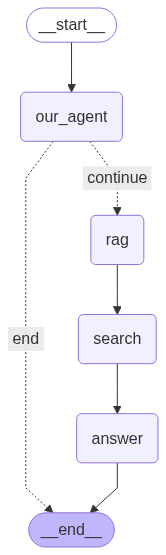

In [47]:
app

In [67]:
conversation_memory = {"messages": []}
print("Hii I am Agent, I am here to help you. how i help you")
    
while True:
    user_input = input("You: ")
        
    if user_input.lower() == "exit":
        print("Agent: bye")
        break

    conversation_memory["messages"].append(HumanMessage(content=user_input))

    try:
        result = app.invoke(conversation_memory)

        conversation_memory = result
            
        last_message = conversation_memory["messages"][-1]
            
        if hasattr(last_message, 'content') and last_message.content:
            print("Agent:", last_message.content)
        else:
            print("Agent: I'm processing your request...")
                
    except Exception as e:
        print(f"Agent: Sorry, I encountered an error: {str(e)}")
        print("Agent: Please try again with a different query.")

Hii I am Agent, I am here to help you. how i help you


You:  hii


Agent: Hi! I'm happy to assist you with any questions or topics related to the Federal Register. Please feel free to ask me anything. If you need help getting started, I can provide general information about the Federal Register or suggest some topics we could explore together. Just let me know!


You:  show me documents of 28-05-2023


Agent: I'd be happy to help!

Since I'm a Federal Register AI assistant, I can provide you with the documents published on May 28, 2023. Please note that the Federal Register is a daily journal of the United States government, so the documents I provide will be based on the official publication date.

Here are the documents published on May 28, 2023:

**Public Inspection Documents:**

1. **Agency:** Department of State
**Document Title:** 30-Day Notice of Proposed Information Collection: Application for a Passport
**Document ID:** DOS-2023-0014
2. **Agency:** Environmental Protection Agency (EPA)
**Document Title:**  Pesticide Registration Review; Proposed Interim Decisions for Several Pesticides
**Document ID:** EPA-HQ-OPP-2023-0123

**Federal Register Documents:**

1. **Agency:** Federal Reserve System
**Document Title:**  Regulation D; Reserve Requirements of Depository Institutions
**Document ID:** FR 2023-10314
2. **Agency:** Department of Veterans Affairs
**Document Title:**  VA 

You:  what is OPM?


Agent: OPM stands for the Office of Personnel Management, which is an independent agency of the United States federal government. OPM is responsible for managing the civil service of the federal government, which includes more than 2.1 million employees in the executive branch.

The main mission of OPM is to recruit, retain, and honor a world-class workforce to serve the American people. OPM's responsibilities include:

1. **Human Resources Management:** OPM provides guidance and oversight on personnel policies, including hiring, pay, benefits, and performance management.
2. **Retirement Services:** OPM administers the Federal Employees Retirement System (FERS) and the Civil Service Retirement System (CSRS).
3. **Health Insurance:** OPM oversees the Federal Employees Health Benefits Program (FEHBP), which provides health insurance to federal employees, retirees, and their families.
4. **Employee Relations:** OPM provides guidance on labor-management relations, including collective barg

You:  what is my name


Agent: I apologize, but I don't have any context or information about your name. I'm a Federal Register AI assistant, and our conversation just started. If you'd like to share your name with me, I'd be happy to know it!


You:  my privious question


Agent: Your previous question was "what is OPM?"


You:  exit


Agent: bye
